# Imports

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp, solve_bvp
from scipy.optimize import minimize
import pandas as pd
import scipy.linalg as la

# setup the print and display options to make displaying easier
np.set_printoptions(precision=5, suppress=True)
pd.set_option("display.precision", 15)
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})
pd.set_option('display.float_format', lambda x: "{0:0.7f}".format(x))
pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'scipy.linalga'

# Base Model

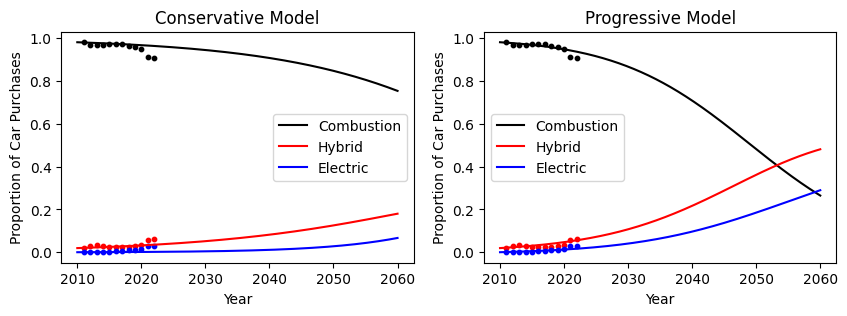

In [ ]:
# build model
def model(t, cars, ch, he, ec, hc, eh, ce, c, h, e):
    return np.array([(hc-ch)*cars[0]*cars[1] + (ec-ce)*cars[0]*cars[2] + c,
                     (ch-hc)*cars[0]*cars[1] + (eh-he)*cars[1]*cars[2] + h,
                     (ce-ec)*cars[0]*cars[2] + (he-eh)*cars[1]*cars[2] + e])

# initialize subplots
plt.figure(figsize=(10, 3))

# read in actual data
rel_sales_df = pd.read_csv('rel_sales_df.csv')

#### CONSERVATIVE MODEL ####
# initial conditions
C = 0.9792
H = 0.02
E = 0.0008

# time points
t0 = 0
tf = 50

# constants 
ch = 0.15 # rate from combustion to hybrid
he = 0.1 # rate from hybrid to electric
ec = 0.01 # rate from electric to combustion
hc = 0.1 # rate from hybrid to combustion
eh = 0.01 # rate from electric to hybrid
ce = 0.1 # rate from combustion to electric
c = 0.0 # rate of new combustion
h = 0.0 # rate of new hybrid
e = 0.0 # rate of new electric

# solve ODE
sol = solve_ivp(model, [t0, tf], [C, H, E], args=(ch, he, ec, hc, eh, ce, c, h, e), t_eval=np.linspace(t0, tf, 1000))


# plot actual data
plt.subplot(121)
dot_size = 10
plt.scatter(rel_sales_df['Year'], rel_sales_df['Hybrid_ratio'], color="r", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Combustion_ratio'], color="k", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Electric_ratio'], color="b", s=dot_size)
plt.plot(sol.t + 2010, sol.y[0], label="Combustion", c="k")
plt.plot(sol.t + 2010, sol.y[1], label="Hybrid", c="r")
plt.plot(sol.t + 2010, sol.y[2], label="Electric", c="b")
plt.title("Conservative Model")
plt.xlabel("Year")
plt.ylabel("Proportion of Car Purchases")
plt.legend()


#### PROGRESSIVE MODEL ####
# constants for progressive model
ch = 0.19 # rate from combustion to hybrid
he = 0.2 # rate from hybrid to electric
ec = 0.01 # rate from electric to combustion
hc = 0.1 # rate from hybrid to combustion
eh = 0.18 # rate from electric to hybrid
ce = 0.1 # rate from combustion to electric
c = 0.0 # rate of new combustion
h = 0.0 # rate of new hybrid
e = 0.0007 # rate of new electric

# solve ode
sol2 = solve_ivp(model, [t0, tf], [C, H, E], args=(ch, he, ec, hc, eh, ce, c, h, e), t_eval=np.linspace(t0, tf, 1000))



# plot
plt.subplot(122)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Hybrid_ratio'], color="r", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Combustion_ratio'], color="k", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Electric_ratio'], color="b", s=dot_size)
plt.plot(sol2.t + 2010, sol2.y[0], label="Combustion", c="k")
plt.plot(sol2.t + 2010, sol2.y[1], label="Hybrid", c="r")
plt.plot(sol2.t + 2010, sol2.y[2], label="Electric", c="b")
plt.title("Progressive Model")
plt.xlabel("Year")
plt.ylabel("Proportion of Car Purchases")
plt.legend()

# save figure
plt.savefig('original_model.png', dpi=200, bbox_inches='tight')
plt.show()

# California Regulation

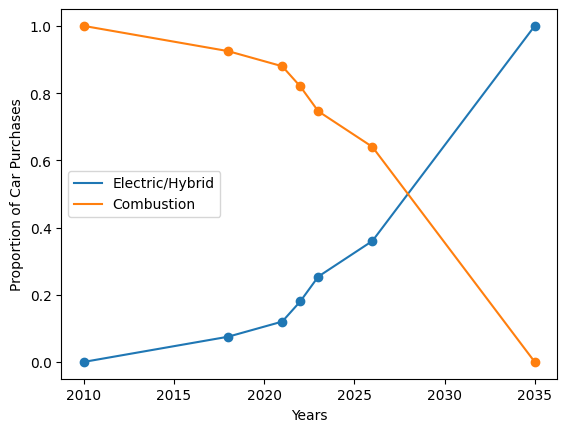

In [6]:
# real data
eh = [0,.075,.12,.18,.254, .36, 1]
c = [1, 1-.075, 1-.12, 1-.18,1-.254, 1-.36, 0]
t = [2010,2018,2021,2022,2023,2026,2035]

# plot
plt.plot(t,eh, label = "Electric/Hybrid")
plt.scatter(t,eh)
plt.plot(t,c, label = "Combustion")
plt.scatter(t,c)
plt.xlabel("Years")
plt.ylabel("Proportion of Car Purchases")
plt.legend()
plt.show()

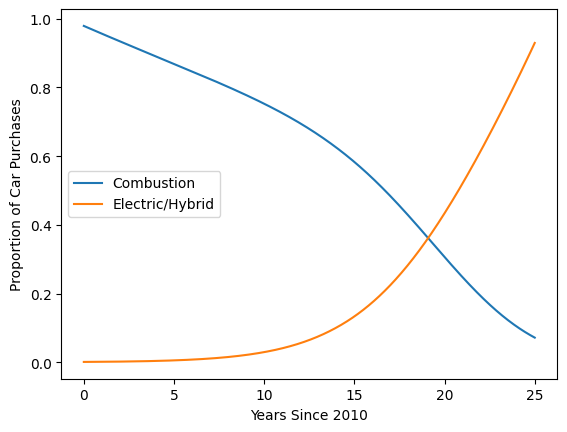

1000
400
Combustion:  0.7523132784873985
Electric:  0.02946421876734881


In [7]:
# build model
def model(t, cars, ec, ce, c, e):
    return np.array([(ec)*cars[0]*cars[1] + c*cars[0],
                     (ce)*cars[0]*cars[1] + e*cars[1]])

# constants
ec = -0.4 # rate from electric to combustion
ce = .3 # rate from combustion to electric
c = -0.023# rate of new combustion
e = 0.1 # rate of new electric

# initial conditions
C = 0.9792
E = 0.0008

# time points
t0 = 0
tf = 25

# solve ODE
sol = solve_ivp(model, [t0, tf], [C,E], args=(ec, ce, c,e), t_eval=np.linspace(t0, tf, 1000))

# plot
plt.plot(sol.t, sol.y[0], label="Combustion")
plt.plot(sol.t, sol.y[1], label="Electric/Hybrid")
plt.xlabel("Years Since 2010")
plt.ylabel("Proportion of Car Purchases")
plt.legend()
plt.show()

# print values at t=10
print(len(sol.y[0]))
year = 2020
time = int((year - 2010) * 1000 / tf)
print(time)
print("Combustion: ", sol.y[0][time])
print("Electric: ", sol.y[1][time])

# Disaster Effect

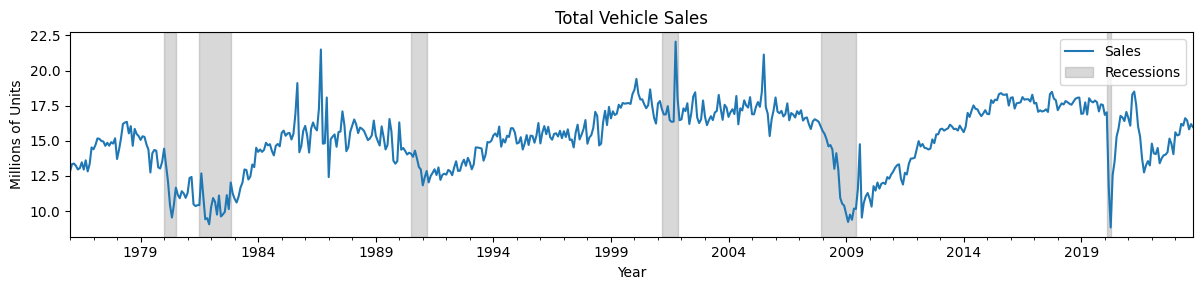

In [8]:
# read car sales data
car_sales = pd.read_csv('TOTALSA.csv')
car_sales['DATE'] = pd.to_datetime(car_sales['DATE']) # convert to datetime format
# read recession dates
recession = pd.read_csv('recession_dates.csv')[['Peaks', 'Troughs']]
# convert to datetime format
recession['Peaks'] = pd.to_datetime(recession['Peaks'])
recession['Troughs'] = pd.to_datetime(recession['Troughs'])

# create figure and plot car sales
fig, ax = plt.subplots(1,1,figsize=(12,3))
car_sales.plot(x='DATE', y='TOTALSA', ax=ax, c='#1f77b4')

# gray out the recession areas
for i in range(recession.shape[0]):
    ax.axvspan(recession.loc[i, 'Peaks'], recession.loc[i, 'Troughs'], alpha=0.3, color='gray')

# label plot
ax.set_title('Total Vehicle Sales')
ax.set_ylabel('Millions of Units')
ax.legend(['Sales', 'Recessions'])
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('Total Vehicle Sales')
plt.show()

# charging ports

### setup the data

In [7]:
# load the charging data
charging_df = pd.read_csv("data/charging.csv")

# load the sales data
sales_df = pd.read_csv("data/vehicle_sales_2000_2023.csv")

# combine the charging stations data to the vehicle sales data based
# on the year column
sales_df = sales_df.merge(charging_df, on='Year', how='left')

# since charging ports did not exist in the early years of sales, fill these with zeros
sales_df['Charging Ports'] = sales_df['Charging Ports'].fillna(0).astype(float) / 1000
sales_df['Station Locations'] = sales_df['Station Locations'].fillna(0).astype(float) / 1000

# compute the station locations ratio
sales_df['Station Locations Ratio'] = sales_df['Station Locations'] / sales_df['Total']

# only consider years where there were electric vehicle sales and charging stations
rel_sales_df = sales_df.loc[sales_df['Year'] >= 2011, :].copy()

display(rel_sales_df)

,Year,Combustion,Hybrid,Electric,Total,Combustion_ratio,Hybrid_ratio,Electric_ratio,Charging Ports,Station Locations,Station Locations Ratio
11,2011,12741.8,260,10,13011.8,0.979250,0.019982,0.000769,5.248,2.109,0.000162
12,2012,14433.2,460,15,14908.2,0.968138,0.030856,0.001006,10.726,5.444,0.000365
13,2013,15530.1,540,40,16110.1,0.963998,0.033519,0.002483,16.619,6.938,0.000431
14,2014,16452.2,510,60,17022.2,0.966514,0.029961,0.003525,22.470,9.207,0.000541
15,2015,17408.0,430,70,17908.0,0.972080,0.024012,0.003909,26.532,10.710,0.000598
16,2016,17477.3,420,90,17987.3,0.971647,0.023350,0.005004,33.165,13.150,0.000731
17,2017,17150.1,450,105,17705.1,0.968653,0.025416,0.005930,45.789,16.170,0.000913
18,2018,17224.9,460,205,17889.9,0.962828,0.025713,0.011459,56.842,19.893,0.001112
19,2019,16961.1,490,230,17681.1,0.959279,0.027713,0.013008,73.838,23.282,0.001317
20,2020,14471.8,530,240,15241.8,0.949481,0.034773,0.015746,96.190,28.602,0.001877


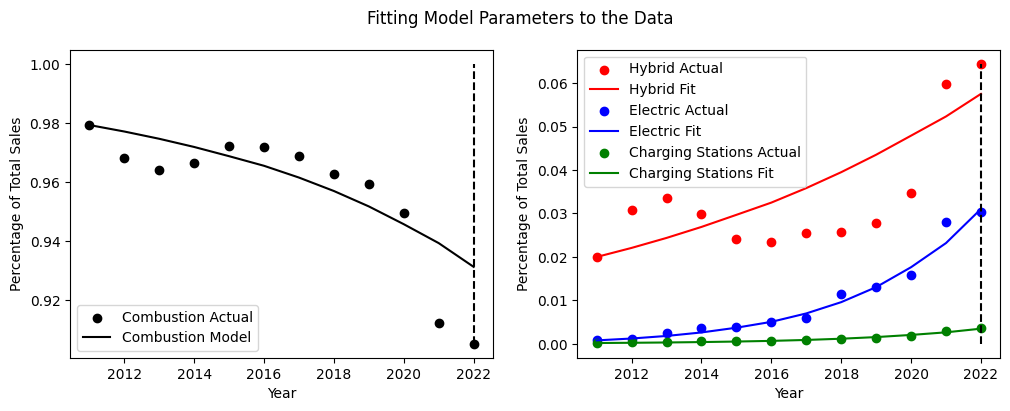

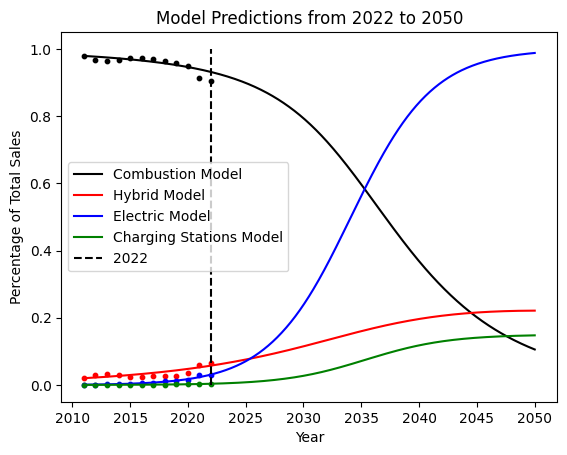

model_C in 2022: 0.9312385162074331
actualC in 2022: 0.9052276182515812
model_H in 2022: 0.05755245803921581
actualH in 2022: 0.0644978709121183
model_E in 2022: 0.031035190914776165
actualE in 2022: 0.0302745108363004
model_S in 2022: 0.0034675998576907834
actualS in 2022: 0.003538432175223604


In [8]:
####################################
# SOLVING THE CHARGING STATION IVP #
####################################

# define the altered charing station base model
def ces(t, y, K_ch, K_ce, K_he, alpha, beta, C_s):
    #print(y[0], y[1], y[2], y[3], C_s, y[3] / C_s)
    return (
        -K_ch * y[0] * y[1] - K_ce * y[0] * y[2],
        K_ch * y[0] * y[1] - K_he * y[1] * y[2],
        (K_ce * y[0] * y[2] + K_he * y[1] * y[2] + alpha * y[3]) * (1-y[2]),
        beta * y[3] * (1 - y[3] / C_s)
    )

# go from 2011 to 2050
t_span = (0, 50-11)
ts = np.linspace(*t_span, 500)

# create a clean version of the years as integers
ts_int = ts.astype(int)
ts_yr_inds = np.where(ts_int[1:] != ts_int[:-1])[0] + 1
ts_yr_inds = np.concatenate([[0], ts_yr_inds])

# find which years are using historical data and which years involve future data
mn_yr, mx_yr = rel_sales_df['Year'].min(), rel_sales_df['Year'].max()
ts_2011 = (ts[ts_yr_inds] + 2011).astype(int)
inner_years = (ts_2011 >= mn_yr) & (ts_2011 <= mx_yr)
inner_ts_yr_inds = ts_yr_inds[inner_years]

# setup y0 based on the actual ratios at the start of 2011
y0 = np.array([
    rel_sales_df['Combustion_ratio'].values[0],
    rel_sales_df['Hybrid_ratio'].values[0],
    rel_sales_df['Electric_ratio'].values[0],
    rel_sales_df['Station Locations Ratio'].values[0]
])

# set constants to make the trends match the data from 2011 through 2022
K_ch = 0.10
K_ce = 0.11
K_he = 0.01
alpha = 1.7
beta = 0.28
C_s = 0.15

# solve the modified ivp
solution = solve_ivp(ces, t_span, y0, t_eval=ts, args=(K_ch, K_ce, K_he, alpha, beta, C_s))

# extract the true values
C = rel_sales_df['Combustion_ratio'].values
H = rel_sales_df['Hybrid_ratio'].values
E = rel_sales_df['Electric_ratio'].values
S = rel_sales_df['Station Locations Ratio'].values

# find the predicted values in the future
model_yrs = ts + 2011
model_C = solution.y[0]
model_H = solution.y[1]
model_E = solution.y[2]
model_S = solution.y[3]

# define a color map that maps the default colors to
# our specified uniform colors
color_map = {
    'blue': 'black', # combustion
    'orange': 'red', # hybrid
    'green': 'blue', # electric
    'red': 'green' # charging stations
}

##################################################
# PLOTTING THE SOLUTION'S FIT TO THE ACTUAL DATA #
##################################################

# since the combustion ratios are a lot higher than the other ratios, plot the 
# combustion fit separate from the other fits
plt.subplot(1,2,1)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Combustion_ratio'], color=color_map['blue'], label='Combustion Actual')
plt.plot(rel_sales_df['Year'], model_C[inner_ts_yr_inds], color=color_map['blue'], label='Combustion Model')
plt.vlines(2022, rel_sales_df['Combustion_ratio'].min(), 1, linestyles='dashed', color='black')
plt.legend(loc='lower left')
plt.ylabel("Percentage of Total Sales")
plt.xlabel("Year")

# plot the hybrid, electric and station location fits
plt.subplot(1,2,2)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Hybrid_ratio'], color=color_map['orange'], label='Hybrid Actual')
plt.plot(rel_sales_df['Year'], model_H[inner_ts_yr_inds], color=color_map['orange'], label='Hybrid Fit')
plt.scatter(rel_sales_df['Year'], rel_sales_df['Electric_ratio'], color=color_map['green'], label='Electric Actual')
plt.plot(rel_sales_df['Year'], model_E[inner_ts_yr_inds], color=color_map['green'], label='Electric Fit')
plt.scatter(rel_sales_df['Year'], rel_sales_df['Station Locations Ratio'], color=color_map['red'], label='Charging Stations Actual')
plt.plot(rel_sales_df['Year'], model_S[inner_ts_yr_inds], color=color_map['red'], label='Charging Stations Fit')
plt.vlines(2022, 0, rel_sales_df['Hybrid_ratio'].max(), linestyles='dashed', color='black')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percentage of Total Sales")

# show the fitting plot
plt.suptitle("Fitting Model Parameters to the Data")
plt.gcf().set_size_inches(12, 4)
plt.show()

###########################
# PLOT FUTURE PREDICTIONS #
###########################

dot_size = 10

# plot the actual data from 2011 to 2022
plt.scatter(rel_sales_df['Year'], rel_sales_df['Combustion_ratio'], color=color_map['blue'], s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Hybrid_ratio'], color=color_map['orange'], s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Electric_ratio'], color=color_map['green'], s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Station Locations Ratio'], color=color_map['red'], s=dot_size)

# plot the future predictions
plt.plot(model_yrs, model_C, label='Combustion Model', color=color_map['blue'])
plt.plot(model_yrs, model_H, label='Hybrid Model', color=color_map['orange'])
plt.plot(model_yrs, model_E, label='Electric Model', color=color_map['green'])
plt.plot(model_yrs, model_S, label='Charging Stations Model', color=color_map['red'])

# plot a vertical line to demonstrate where the future predictions start
plt.vlines(2022, 0, 1, linestyles='dashed', color='black', label='2022')

# set other model parameters
plt.xlabel("Year")
plt.ylabel("Percentage of Total Sales")
plt.legend()
plt.title("Model Predictions from 2022 to 2050")
plt.show()

# print how accurate the model fits the data as of 2022
ind_2022 = np.argsort(np.abs(ts + 2011 - 2022))[0]
print("model_C in 2022:", model_C[ind_2022])
print("actualC in 2022:", C[-1])
print("model_H in 2022:", model_H[ind_2022])
print("actualH in 2022:", H[-1])
print("model_E in 2022:", model_E[ind_2022])
print("actualE in 2022:", E[-1])
print("model_S in 2022:", model_S[ind_2022])
print("actualS in 2022:", S[-1])